In [22]:
import pandas as pd
from pathlib import Path

background_map = {
    'The city of London': 'The city of London',
    'The Parthenon in front of the Great Pyramid': 'The Parthenon in front of the Great Pyramid',
    'A single beam of light enters the room from the ceiling The beam of light is illuminating an easel On the easel there is a Rembrandt painting of a raccoon': 'A single beam of light enters the room from the ceiling. The beam of light is illuminating an easel. On the easel, there is a Rembrandt painting of a raccoon.',
    'A sunset': 'A sunset',
    'Photograph of a wall along a city street with a watercolor mural of foes in a jazz band': 'Photograph of a wall along a city street with a watercolor mural of foxes in a jazz band.'
}

clothes_map = {
    'A_scientist': 'A scientist',
    'A_photograph_of_a_knight_in_shining_armor_holding_a_basketball': 'A photograph of a knight in shining armor holding a basketball',
    'The_Mona_Lisa': 'The Mona Lisa',
    'Salvador_Dalí': 'Salvador Dalí',
    'A_person_with_arms_like_a_tree_branch': 'A person with arms like a tree branch'
}

def parse_threshold(th_str: str) -> float:
    return int(th_str[2:]) / 10.0

rows = []
for file in sorted(Path('experiment').glob('*.jpg')):
    name = file.name
    parts = name[:-4].split('__')
    img_name = parts[0]
    background_raw = parts[2]
    th_raw = parts[3]
    clothing_raw = parts[4]
    row = {
        'nome_arquivo': name,
        'imagem': img_name,
        'threshold': parse_threshold(th_raw),
        'prompt_fundo': background_map.get(background_raw, background_raw),
        'prompt_roupa': clothes_map.get(clothing_raw, clothing_raw.replace('_', ' '))
    }
    rows.append(row)

df = pd.DataFrame(rows)


In [23]:

import torch
import clip
from PIL import Image
from torchvision import transforms as T
from torchmetrics.image.fid import FrechetInceptionDistance

REFERENCE_IMAGES = {
    'Photograph of a wall along a city street with a watercolor mural of foxes in a jazz band.': 'reference_images/fox_mural.png',
    'The city of London': 'reference_images/london.png',
    'The Parthenon in front of the Great Pyramid': 'reference_images/partenon_great_pyramid.png',
    'A sunset': 'reference_images/sunset.png',
    'A single beam of light enters the room from the ceiling. The beam of light is illuminating an easel. On the easel, there is a Rembrandt painting of a raccoon.': 'reference_images/racoon.png',
    'A scientist': 'reference_images/scientist.png',
    'A photograph of a knight in shining armor holding a basketball': 'reference_images/knight_basketball.png',
    'The Mona Lisa': 'reference_images/monalisa.jpg',
    'Salvador Dalí': 'reference_images/salvador_dali.jpeg',
    'A person with arms like a tree branch': 'reference_images/tree_arms.png'
}

fid_transform = None

def setup_fid_transform():
    global fid_transform
    fid_transform = T.Compose([T.Resize((299, 299)), T.ToTensor()])

def compute_clip_score(image_path, prompt, model, preprocess, device):
    image = preprocess(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    text = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        img_feat = model.encode_image(image)
        txt_feat = model.encode_text(text)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        txt_feat /= txt_feat.norm(dim=-1, keepdim=True)
        score = (img_feat @ txt_feat.T).squeeze().cpu().item()
    return float(score)

def compute_fid(image_path, ref_path, fid_metric):
    if fid_transform is None:
        setup_fid_transform()
    img = fid_transform(Image.open(image_path).convert('RGB')).unsqueeze(0)
    ref = fid_transform(Image.open(ref_path).convert('RGB')).unsqueeze(0)
    fid_metric.reset()
    fid_metric.update(ref, real=True)
    fid_metric.update(img, real=False)
    return float(fid_metric.compute().item())


In [24]:
# -*- coding: utf-8 -*-
"""
CLIPScore (imagem x texto) com duas colunas:
- clip_fundo: similaridade da imagem com o prompt do fundo (prompt_fundo)
- clip_inpainting: similaridade da imagem com o prompt de inpainting/roupa (prompt_roupa)

Requisitos no DataFrame 'df':
  ['nome_arquivo', 'prompt_roupa', 'prompt_fundo']

Imagens em: 'experiment/<nome_arquivo>'

Saída: 'experiment_metrics.csv' com as colunas:
  ['nome_arquivo', ..., 'clip_fundo', 'clip_inpainting']
"""

from __future__ import annotations
import os
from pathlib import Path
from typing import Optional

import torch
import pandas as pd
from PIL import Image

# -------- CLIP oficial --------
try:
    import clip
    assert hasattr(clip, "load"), (
        "O pacote 'clip' importado não tem 'load'. "
        "Desinstale conflitos e instale o CLIP oficial:\n"
        "  pip uninstall -y clip open-clip-torch clip-anytorch\n"
        "  pip install git+https://github.com/openai/CLIP.git"
    )
except Exception as e:
    raise ImportError(
        "Falha ao importar o CLIP oficial.\n"
        "  pip uninstall -y clip open-clip-torch clip-anytorch\n"
        "  pip install git+https://github.com/openai/CLIP.git\n"
        f"Detalhe: {e}"
    )

# =========================
# CONFIG
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

LOAD_DF_FROM_CSV = False       # mude para True se quiser ler de CSV
CSV_PATH = "experiment.csv"    # caminho do CSV (se usar LOAD_DF_FROM_CSV=True)
EXPERIMENT_DIR = Path("experiment")
MAX_IMAGES: Optional[int] = None  # ex.: 200 para testar mais rápido; None = todas

# =========================
# MODELO CLIP
# =========================
print(f"[INFO] Usando device: {device}")
print("[INFO] Carregando modelo CLIP...")
model, preprocess = clip.load("ViT-B/32", device=device)
print("[INFO] Modelo CLIP carregado.")

@torch.no_grad()
def compute_clip_pair(image_path: Path, text_bg: str, text_inp: str) -> tuple[float, float]:
    """
    Retorna (clip_fundo, clip_inpainting) para uma mesma imagem.
    Faz um único encode da imagem; tokeniza os dois textos de uma vez.
    """
    image = Image.open(image_path).convert("RGB")
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Tokeniza os dois prompts juntos
    texts = [text_bg, text_inp]
    text_tokens = clip.tokenize(texts).to(device)

    # Features
    img_feat = model.encode_image(image_input)                  # (1, D)
    txt_feat = model.encode_text(text_tokens)                   # (2, D)

    # Normalização L2
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)  # (1, D)
    txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)  # (2, D)

    # Similaridades: (1,D) @ (D,2) -> (1,2)
    sims = (img_feat @ txt_feat.T).squeeze(0)                  # (2,)
    clip_fundo = float(sims[0].item())
    clip_inpainting = float(sims[1].item())
    return clip_fundo, clip_inpainting

# =========================
# DADOS
# =========================
if "df" not in globals() and LOAD_DF_FROM_CSV:
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV '{CSV_PATH}' não encontrado.")
    print(f"[INFO] Lendo CSV: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)

required_cols = {"nome_arquivo", "prompt_roupa", "prompt_fundo"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"O DataFrame 'df' não contém as colunas obrigatórias: {missing}")

df_proc = df if MAX_IMAGES is None else df.head(int(MAX_IMAGES)).copy()
print(f"[INFO] Processando {len(df_proc)} imagens.")

# =========================
# LOOP PRINCIPAL
# =========================
clip_fundo_scores = []
clip_inp_scores = []

for idx, row in df_proc.iterrows():
    img_path = EXPERIMENT_DIR / str(row["nome_arquivo"])
    print(f"\n[PROCESSANDO] {idx+1}/{len(df_proc)} - {img_path.name}")

    if not img_path.exists():
        print(f"[AVISO] Imagem não encontrada, pulando: {img_path}")
        clip_fundo_scores.append(float("nan"))
        clip_inp_scores.append(float("nan"))
        continue

    text_bg = str(row["prompt_fundo"])
    text_inp = str(row["prompt_roupa"])

    try:
        clip_fundo, clip_inpainting = compute_clip_pair(img_path, text_bg, text_inp)
        print(f"  - CLIP (fundo):       {clip_fundo:.4f}")
        print(f"  - CLIP (inpainting):  {clip_inpainting:.4f}")
    except Exception as e:
        print(f"[ERRO CLIP] {img_path}: {e}")
        clip_fundo, clip_inpainting = float("nan"), float("nan")

    clip_fundo_scores.append(clip_fundo)
    clip_inp_scores.append(clip_inpainting)

# =========================
# SALVAR
# =========================
df_out = df.copy()
df_proc_out = df_proc.copy()
df_proc_out["clip_fundo"] = clip_fundo_scores
df_proc_out["clip_inpainting"] = clip_inp_scores

df_out = df_out.merge(
    df_proc_out[["nome_arquivo", "clip_fundo", "clip_inpainting"]],
    on="nome_arquivo",
    how="left"
)

out_path = "experiment_metrics.csv"
df_out.to_csv(out_path, index=False)
print(f"\n[FINALIZADO] CLIP (fundo & inpainting) salvos em: {out_path}")
print(df_out.head(10))


[INFO] Usando device: cuda
[INFO] Carregando modelo CLIP...
[INFO] Modelo CLIP carregado.
[INFO] Processando 6000 imagens.

[PROCESSANDO] 1/6000 - img-03-mscoco__fundo_0015__A single beam of light enters the room from the ceiling The beam of light is illuminating an easel On the easel there is a Rembrandt painting of a raccoon__th01__A_scientist.jpg
  - CLIP (fundo):       0.1388
  - CLIP (inpainting):  0.2418

[PROCESSANDO] 2/6000 - img-03-mscoco__fundo_0015__A sunset__th01__A_scientist.jpg
  - CLIP (fundo):       0.1989
  - CLIP (inpainting):  0.2443

[PROCESSANDO] 3/6000 - img-03-mscoco__fundo_0015__The Parthenon in front of the Great Pyramid__th01__A_scientist.jpg
  - CLIP (fundo):       0.1254
  - CLIP (inpainting):  0.2384

[PROCESSANDO] 4/6000 - img-03-mscoco__fundo_0015__The city of London__th01__A_scientist.jpg
  - CLIP (fundo):       0.1888
  - CLIP (inpainting):  0.2625

[PROCESSANDO] 5/6000 - img-03-mscoco__fundo_0039__A single beam of light enters the room from the ceiling

In [25]:
import re
import numpy as np
import pandas as pd

# Usa df_out diretamente
_df = df_out.copy()

# Verificações de colunas
required = {'nome_arquivo', 'clip_fundo', 'clip_inpainting'}
missing = required - set(_df.columns)
if missing:
    raise ValueError(f"Faltam colunas obrigatórias em df_out: {missing}")

# Extrai/usa threshold existente
threshold_col = None
for candidate in ['threshold', 'limiar', 'th', 'thr']:
    if candidate in _df.columns:
        threshold_col = candidate
        break

if threshold_col is None:
    def _extract_threshold_label(name: str):
        s = str(name)
        m = re.search(r'__th([A-Za-z0-9\.\-]+)__', s)
        if m: return f"th{m.group(1)}"
        m = re.search(r'_th([A-Za-z0-9\.\-]+)_', s)
        if m: return f"th{m.group(1)}"
        m = re.search(r'th([A-Za-z0-9\.\-]+)', s)
        if m: return f"th{m.group(1)}"
        return np.nan
    _df['threshold_label'] = _df['nome_arquivo'].apply(_extract_threshold_label)
else:
    _df['threshold_label'] = _df[threshold_col].astype(str)

# Filtra válidos
_df = _df[
    ~_df['threshold_label'].isna() &
    ~_df['clip_fundo'].isna() &
    ~_df['clip_inpainting'].isna()
].copy()
if _df.empty:
    raise ValueError("Sem linhas válidas com 'threshold_label', 'clip_fundo' e 'clip_inpainting'.")

# (opcional) Ordenação por rótulo (categórica, estável)
_df = _df.sort_values('threshold_label')

# # (opcional) Ordenação por valor numérico do threshold:
# def _parse_th_num(lbl: str):
#     m = re.search(r'([\-\d\.]+)', str(lbl))
#     try:
#         return float(m.group(1)) if m else np.nan
#     except:
#         return np.nan
# order_map = (_df[['threshold_label']]
#              .drop_duplicates()
#              .assign(th_num=lambda d: d['threshold_label'].map(_parse_th_num))
#              .sort_values('th_num'))
# order_list = order_map['threshold_label'].tolist()
# _df['threshold_label'] = pd.Categorical(_df['threshold_label'], categories=order_list, ordered=True)
# _df = _df.sort_values('threshold_label')

# Médias por threshold
means_bg = (_df.groupby('threshold_label')['clip_fundo']
            .mean()
            .reset_index(name='clip_fundo_mean'))

means_inp = (_df.groupby('threshold_label')['clip_inpainting']
             .mean()
             .reset_index(name='clip_inpainting_mean'))

# Junta em uma só tabela
means_df = pd.merge(means_bg, means_inp, on='threshold_label', how='outer').sort_values('threshold_label').reset_index(drop=True)

print("Médias de CLIP por threshold:")
print(means_df.to_string(index=False))

# Guarda para o plot
means_for_plot = means_df.copy()   # columns: threshold_label, clip_fundo_mean, clip_inpainting_mean


Médias de CLIP por threshold:
threshold_label  clip_fundo_mean  clip_inpainting_mean
            0.1         0.181788              0.301130
            0.3         0.217689              0.286896
            0.5         0.228162              0.279932
            0.7         0.236744              0.274222
            0.9         0.241167              0.271499
            1.1         0.246089              0.268017
            1.3         0.260885              0.255304
            1.5         0.271997              0.241415
            1.7         0.280018              0.231816
            1.9         0.290250              0.221413


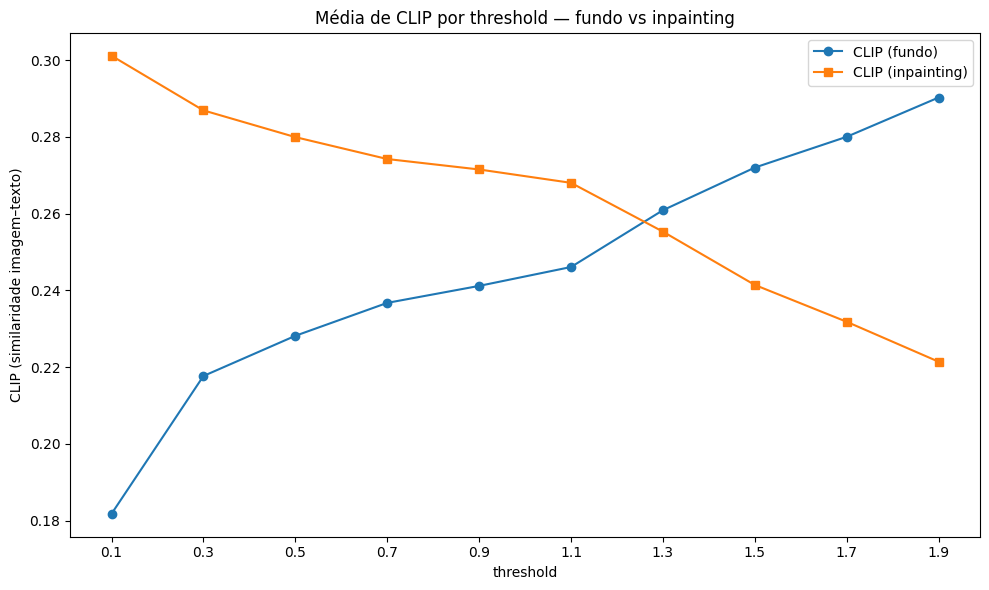

In [26]:
import matplotlib.pyplot as plt

if 'means_for_plot' not in globals():
    raise RuntimeError("Execute primeiro a célula de pré-cálculo.")

# Eixo X categórico (posições 1..N) com labels = thresholds
thresholds = means_for_plot['threshold_label'].tolist()
x = list(range(1, len(thresholds) + 1))

y_bg  = means_for_plot['clip_fundo_mean'].values
y_inp = means_for_plot['clip_inpainting_mean'].values

plt.figure(figsize=(10, 6))
plt.plot(x, y_bg,  marker='o', label='CLIP (fundo)')
plt.plot(x, y_inp, marker='s', label='CLIP (inpainting)')

plt.xticks(x, thresholds, rotation=0)
plt.xlabel("threshold")
plt.ylabel("CLIP (similaridade imagem–texto)")
plt.title("Média de CLIP por threshold — fundo vs inpainting")
plt.legend()
plt.tight_layout()
plt.show()


# FID

In [27]:
# -*- coding: utf-8 -*-
"""
FID por imagem (duas colunas): fid_fundo e fid_inpainting — APENAS threshold = 1.3
- Aceita múltiplas referências por prompt (ex.: monalisa.jpg e monalisa_2.jpg).
- Usa TenCrop para garantir >=2 amostras por distribuição.
- Filtra df para processar somente as linhas com threshold 1.3 (extraído do nome do arquivo).
- Salva 'experiment_metrics.csv' com as novas colunas.
"""

from __future__ import annotations
import os, unicodedata, difflib
from pathlib import Path
from typing import Optional, Dict, Tuple, List, Union
import regex as re  # 'regex' para melhor suporte unicode

import torch
import pandas as pd
from PIL import Image
from torchvision import transforms as T
from torchmetrics.image.fid import FrechetInceptionDistance

# =========================
# CONFIG
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

LOAD_DF_FROM_CSV = False
CSV_PATH = "experiment.csv"

EXPERIMENT_DIR = Path("experiment")
REFERENCE_DIR = Path("reference_images")  # apenas informativo

MAX_IMAGES: Optional[int] = None  # ex.: 200 para testar; None = todas
TARGET_THRESHOLD = 1.3            # << somente este threshold será processado

# ====== MAPEAMENTO: prompt -> caminho base (string OU lista[str]) ======
REFERENCE_IMAGES: Dict[str, Union[str, List[str]]] = {
    'Photograph of a wall along a city street with a watercolor mural of foxes in a jazz band.': 'reference_images/fox_mural.png',
    'The city of London': 'reference_images/london.png',
    'The Parthenon in front of the Great Pyramid': 'reference_images/partenon_great_pyramid.png',
    'A sunset': 'reference_images/sunset.png',
    'A single beam of light enters the room from the ceiling. The beam of light is illuminating an easel. On the easel, there is a Rembrandt painting of a raccoon.': 'reference_images/racoon.png',
    'A scientist': 'reference_images/scientist.png',
    'A photograph of a knight in shining armor holding a basketball': 'reference_images/knight_basketball.png',
    'The Mona Lisa': 'reference_images/monalisa.jpg',
    'Salvador Dalí': 'reference_images/salvador_dali.jpeg',
    'A person with arms like a tree branch': 'reference_images/tree_arms.png'
}

# =========================
# NORMALIZAÇÃO/MATCH DE PROMPTS
# =========================
_punct_re = re.compile(r"[^\w\s]", flags=re.UNICODE)

def normalize_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s).replace("_", " ")
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    s = _punct_re.sub(" ", s).lower().strip()
    s = " ".join(s.split())
    return s

from typing import Iterable
def _expand_to_paths(entry: Union[str, List[str]]) -> List[Path]:
    """Aceita string ou lista de strings; inclui automaticamente *_2.ext se existir."""
    paths: List[Path] = []
    entries: Iterable[str] = [entry] if isinstance(entry, str) else entry
    for e in entries:
        p = Path(e)
        if p.exists():
            paths.append(p)
        stem, ext = p.stem, p.suffix
        p2 = p.with_name(f"{stem}_2{ext}")
        if p2.exists():
            paths.append(p2)
    # remove duplicatas preservando ordem
    uniq, seen = [], set()
    for p in paths:
        try:
            key = p.resolve()
        except Exception:
            key = p
        if key not in seen:
            uniq.append(p)
            seen.add(key)
    return uniq

def build_norm_map(mapping: Dict[str, Union[str, List[str]]]) -> Dict[str, Tuple[str, List[Path]]]:
    out: Dict[str, Tuple[str, List[Path]]] = {}
    for k, v in mapping.items():
        kn = normalize_text(k)
        paths = _expand_to_paths(v)
        if not paths:
            print(f"[AVISO] Nenhuma referência encontrada para '{k}' -> {v}")
        out[kn] = (k, paths)
    return out

def best_references_for(prompt: str, norm_map: Dict[str, Tuple[str, List[Path]]]) -> Tuple[List[Path], str]:
    key = normalize_text(prompt)
    # 1) exato
    if key in norm_map and norm_map[key][1]:
        orig, paths = norm_map[key]
        return paths, f"match exato ('{orig}')"
    # 2) substring
    for k_norm, (orig, paths) in norm_map.items():
        if paths and (key in k_norm or k_norm in key):
            return paths, f"match aproximado ('{prompt}' ~ '{orig}')"
    # 3) sugestões
    suggestions = difflib.get_close_matches(key, list(norm_map.keys()), n=3, cutoff=0.6)
    if suggestions:
        s_list = [norm_map[s][0] for s in suggestions]
        return [], f"nenhuma referência compatível; sugestões: {s_list} | prompt_norm='{key}'"
    return [], f"nenhuma referência compatível; prompt_norm='{key}'"

def same_file(p1: Path, p2: Path) -> bool:
    try:
        return p1.resolve() == p2.resolve()
    except Exception:
        return str(p1) == str(p2)

# =========================
# EXTRAÇÃO DE THRESHOLD
# =========================
# Suporta "__th1.3__", "_th1.3_", "th1.3"; e variação sem ponto "__th13__" (mapeada para 1.3)
_th_patterns = [
    re.compile(r'__th([0-9]+(?:\.[0-9]+)?)__', flags=re.IGNORECASE),
    re.compile(r'_th([0-9]+(?:\.[0-9]+)?)_',   flags=re.IGNORECASE),
    re.compile(r'th([0-9]+(?:\.[0-9]+)?)',     flags=re.IGNORECASE),
    re.compile(r'__th([0-9]{1,3})__',          flags=re.IGNORECASE),  # ex.: __th13__
    re.compile(r'_th([0-9]{1,3})_',            flags=re.IGNORECASE),
]

def parse_threshold_from_name(name: str) -> Optional[float]:
    s = str(name)
    for pat in _th_patterns[:3]:
        m = pat.search(s)
        if m:
            return float(m.group(1))
    # tentar forma sem ponto (ex.: 13 -> 1.3) assumindo passo de 0.1
    for pat in _th_patterns[3:]:
        m = pat.search(s)
        if m:
            digits = m.group(1)
            if digits.isdigit():
                if len(digits) == 1:
                    return float(digits) / 10.0
                elif len(digits) == 2:
                    return float(digits[0] + "." + digits[1])
                elif len(digits) == 3:
                    return float(digits[0] + "." + digits[1:3])
                else:
                    return float(digits)
    return None

# =========================
# FID: TRANSFORMS E CÁLCULO
# =========================
print(f"[INFO] Device: {device}")
print("[INFO] Inicializando métrica FID...")
fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
print("[INFO] FID pronto.")

# TenCrop para >=2 amostras
_base_resize = T.Resize(320, interpolation=T.InterpolationMode.BILINEAR, antialias=True)
_ten_crop = T.TenCrop(299)
_to_tensor = T.ToTensor()

@torch.no_grad()
def load_crops_tensor(path: Path) -> torch.Tensor:
    img = Image.open(path).convert("RGB")
    img = _base_resize(img)
    crops = _ten_crop(img)
    tensors = [_to_tensor(c) for c in crops]  # float [0,1]
    return torch.stack(tensors, dim=0)        # (10, 3, 299, 299)

@torch.no_grad()
def compute_fid_pair(img_path: Path, ref_path: Path) -> float:
    if same_file(img_path, ref_path):
        return 0.0
    img_batch = load_crops_tensor(img_path).to(device)
    ref_batch = load_crops_tensor(ref_path).to(device)
    fid_metric.reset()
    fid_metric.update(ref_batch, real=True)
    fid_metric.update(img_batch, real=False)
    return float(fid_metric.compute().item())

@torch.no_grad()
def compute_fid_vs_refs(img_path: Path, ref_paths: List[Path]) -> Optional[float]:
    scores = []
    for rp in ref_paths:
        if not rp.exists():
            print(f"    [AVISO] ref ausente: {rp}")
            continue
        try:
            s = compute_fid_pair(img_path, rp)
            scores.append(s)
        except Exception as e:
            print(f"    [ERRO FID] {img_path.name} vs {rp.name}: {e}")
    if not scores:
        return None
    return float(sum(scores) / len(scores))

# =========================
# DADOS
# =========================
if "df" not in globals() and LOAD_DF_FROM_CSV:
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV '{CSV_PATH}' não encontrado.")
    print(f"[INFO] Lendo CSV: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)

required_cols = {"nome_arquivo", "prompt_roupa", "prompt_fundo"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"O DataFrame 'df' não contém as colunas obrigatórias: {missing}")

# Deriva threshold numérico a partir do nome do arquivo, se não existir coluna
if 'threshold' in df.columns:
    df['threshold_value'] = pd.to_numeric(df['threshold'], errors='coerce')
else:
    df['threshold_value'] = df['nome_arquivo'].map(parse_threshold_from_name)

# Filtra apenas threshold = 1.3 (TARGET_THRESHOLD)
df_t = df[df['threshold_value'].round(3) == float(TARGET_THRESHOLD)].copy()
print(f"[INFO] Filtradas {len(df_t)} linhas com threshold = {TARGET_THRESHOLD}")
if len(df_t) == 0:
    raise ValueError("Nenhuma linha com threshold 1.3 foi encontrada. "
                     "Verifique o padrão no nome do arquivo (ex.: __th1.3__ ou __th13__).")

# Constrói mapa de referências
norm_map = build_norm_map(REFERENCE_IMAGES)

# Debug do mapeamento
print("\n[DEBUG] Referências mapeadas:")
for j, (kn, (orig, paths)) in enumerate(norm_map.items()):
    print(f"  - '{kn}' -> '{orig}' -> {', '.join(str(p) for p in paths) if paths else 'NENHUMA'}")
    if j >= 6:
        print("  ...")
        break

# Subconjunto opcional (para testes rápidos)
df_proc = df_t if MAX_IMAGES is None else df_t.head(int(MAX_IMAGES)).copy()
print(f"\n[INFO] Processando {len(df_proc)} imagens (threshold={TARGET_THRESHOLD})...")

# =========================
# LOOP PRINCIPAL
# =========================
fid_fundo_list: List[Optional[float]] = []
fid_inp_list: List[Optional[float]] = []

for idx, row in df_proc.iterrows():
    img_path = EXPERIMENT_DIR / str(row["nome_arquivo"])
    print(f"\n[PROCESSANDO] {idx+1}/{len(df_proc)} - {img_path.name}")
    if not img_path.exists():
        print(f"[AVISO] Imagem não encontrada, pulando: {img_path}")
        fid_fundo_list.append(None)
        fid_inp_list.append(None)
        continue

    # Fundo
    fundo_refs, reason_b = best_references_for(str(row["prompt_fundo"]), norm_map)
    if fundo_refs:
        print(f"  - Refs fundo ({len(fundo_refs)}): {[p.name for p in fundo_refs]}  [{reason_b}]")
        fid_b = compute_fid_vs_refs(img_path, fundo_refs)
        print(f"  - FID fundo (média sobre refs): {fid_b:.4f}" if fid_b is not None else "  - FID fundo: N/A")
    else:
        print(f"  - FID fundo: N/A  [{reason_b}]")
        fid_b = None

    # Inpainting / Roupa
    inp_refs, reason_c = best_references_for(str(row["prompt_roupa"]), norm_map)
    if inp_refs:
        print(f"  - Refs inpainting ({len(inp_refs)}): {[p.name for p in inp_refs]}  [{reason_c}]")
        fid_c = compute_fid_vs_refs(img_path, inp_refs)
        print(f"  - FID inpainting (média sobre refs): {fid_c:.4f}" if fid_c is not None else "  - FID inpainting: N/A")
    else:
        print(f"  - FID inpainting: N/A  [{reason_c}]")
        fid_c = None

    fid_fundo_list.append(fid_b if fid_b is not None else float("nan"))
    fid_inp_list.append(fid_c if fid_c is not None else float("nan"))

# =========================
# SALVAR
# =========================
df_out = df.copy()
df_proc_out = df_proc.copy()
df_proc_out["fid_fundo"] = fid_fundo_list
df_proc_out["fid_inpainting"] = fid_inp_list

df_out = df_out.merge(
    df_proc_out[["nome_arquivo", "fid_fundo", "fid_inpainting"]],
    on="nome_arquivo",
    how="left"
)

out_path = "experiment_metrics.csv"
df_out.to_csv(out_path, index=False)
print(f"\n[FINALIZADO] FIDs (threshold={TARGET_THRESHOLD}) salvos em: {out_path}")
print(df_out.head(10))


[INFO] Device: cuda
[INFO] Inicializando métrica FID...
[INFO] FID pronto.
[INFO] Filtradas 600 linhas com threshold = 1.3

[DEBUG] Referências mapeadas:
  - 'photograph of a wall along a city street with a watercolor mural of foxes in a jazz band' -> 'Photograph of a wall along a city street with a watercolor mural of foxes in a jazz band.' -> reference_images/fox_mural.png, reference_images/fox_mural_2.png
  - 'the city of london' -> 'The city of London' -> reference_images/london.png, reference_images/london_2.png
  - 'the parthenon in front of the great pyramid' -> 'The Parthenon in front of the Great Pyramid' -> reference_images/partenon_great_pyramid.png, reference_images/partenon_great_pyramid_2.png
  - 'a sunset' -> 'A sunset' -> reference_images/sunset.png, reference_images/sunset_2.png
  - 'a single beam of light enters the room from the ceiling the beam of light is illuminating an easel on the easel there is a rembrandt painting of a raccoon' -> 'A single beam of light enter

KeyboardInterrupt: 